In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import PandasTools, rdMolDescriptors, rdFingerprintGenerator, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize 
from math import log10
from collections import defaultdict
from itertools import combinations
from scipy.linalg import lu

In [2]:
RDLogger.DisableLog('rdApp.*') #Disable RDKit notifications for smiles standardization

In [3]:
def remove_red(red_matrix):
    repeats = {}
    for i in range(red_matrix.shape[0]):
        id_mols = red_matrix[i,:].nonzero()
        id_mols = id_mols[0].tolist()
        if sum(id_mols) > 1:
            repeats[f'molecule_{i}'] = id_mols
    return repeats

def is_diff(activ):
    remove = False
    conv_factors = [3,6,9]
    act_pairs = list(combinations(activ,2))
    for pair in act_pairs:
        diff = pair[1] - pair[0]
        quot = round(pair[1]/pair[0])
        if diff > 0.02 or quot in conv_factors:
            remove = True
    
    return remove

In [4]:
org_df = pd.read_csv('EGFR_Chembl_raw.csv', sep = ';')
org_df.shape

C:\Users\Tim\AppData\Local\Temp\ipykernel_7304\204613330.py:1: DtypeWarning: Columns (3,4,5,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  org_df = pd.read_csv('EGFR_Chembl_raw.csv', sep = ';')


(16715, 46)

In [5]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule ChEMBL ID          16715 non-null  object 
 1   Molecule Name               2246 non-null   object 
 2   Molecule Max Phase          16715 non-null  object 
 3   Molecular Weight            16715 non-null  object 
 4   #RO5 Violations             16715 non-null  object 
 5   AlogP                       16715 non-null  object 
 6   Compound Key                16715 non-null  object 
 7   Smiles                      16683 non-null  object 
 8   Standard Type               16715 non-null  object 
 9   Standard Relation           15336 non-null  object 
 10  Standard Value              15336 non-null  float64
 11  Standard Units              15478 non-null  object 
 12  pChEMBL Value               11990 non-null  float64
 13  Data Validity Comment       367

# Dataset Cleanup
Remove entries that are missing activity values or come from dubious sources.

In [6]:
org_df.dropna(axis = 0, subset = ['Molecule ChEMBL ID','Smiles','Standard Value', 'Standard Units', 'Source Description', 'Source ID'], inplace = True)

In [7]:
org_df['Data Validity Comment'].unique()

array([nan, 'Outside typical range', 'Potential transcription error'],
      dtype=object)

In [8]:
org_df.fillna(value = {'Data Validity Comment':'No Comment'}, inplace = True)
org_df = org_df[org_df['Data Validity Comment'] == 'No Comment']
org_df.shape

(14962, 46)

In [9]:
org_df['Standard Units'].unique()

array(['nM', 'ug.mL-1', '/uM', 'µM'], dtype=object)

In [10]:
org_df = org_df[(org_df['Standard Units'] == 'nM') | (org_df['Standard Units'] == 'ug.mL-1') | (org_df['Standard Units'] == 'µM')]

In [11]:
org_df['Source Description'].unique()

array(['Scientific Literature', 'Patent Bioactivity Data',
       'BindingDB Database', 'DrugMatrix',
       'Donated Chemical Probes - SGC Frankfurt',
       'Literature data from EUbOPEN Chemogenomic Library'], dtype=object)

In [12]:
org_df = org_df[org_df['Standard Relation'] == "'='"]
org_df.shape

(11983, 46)

In [13]:
for i in list(org_df.index):
    if org_df.loc[i,'Standard Units'] == 'nM':
        ic50_M = 10**-9 * float(org_df.loc[i,'Standard Value'])
    elif org_df.loc[i,'Standard Units'] == 'µM':
        ic50_M =  10**-6 * float(org_df.loc[i,'Standard Value'])
    else:
        ic50_M = float(org_df.loc[i,'Standard Value'])/float(org_df.loc[i,'Molecular Weight']) * 10**-3
    
    org_df.loc[i,'pIC50'] = -log10(ic50_M)
    
org_df['pIC50'] = org_df['pIC50'].round(4)
org_df['pIC50'].describe()

count    11983.000000
mean         6.945576
std          1.360156
min          3.647900
25%          5.944900
50%          7.000000
75%          7.984450
max         11.000000
Name: pIC50, dtype: float64

# Repeated Structures
Remove repeated chemical structures.

In [14]:
for i in org_df.index:
    smi = org_df.loc[i,'Smiles']
    try:
        mol = Chem.MolFromSmiles(smi)
        mol = rdMolStandardize.FragmentParent(mol)
        std_smi = Chem.MolToSmiles(mol)
        org_df.loc[i,'Standardized Smiles'] = std_smi
    except:
        pass


In [15]:
PandasTools.AddMoleculeColumnToFrame(org_df,'Standardized Smiles', 'Molecule', includeFingerprints = False)

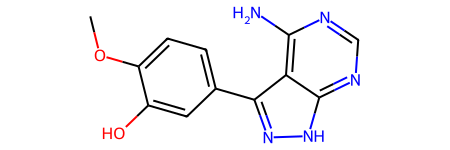

In [16]:
org_df.loc[45,'Molecule']

In [17]:
mol_len = org_df.shape[0]
fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize = 2048)
fps = [fpgen.GetFingerprint(x) for x in org_df['Molecule']]

In [18]:
sim_array = []
for i in range(mol_len):
    sims = i*[0] + DataStructs.BulkTanimotoSimilarity(fps[i],fps[i:])
    sim_array.append(sims)

#Matrix math
self_sim = np.diag(np.array([1]*mol_len))    
sim_array = np.array(sim_array)
sim_array[sim_array != 1] = 0 
sim_array = sim_array + sim_array.T - self_sim

In [19]:
org_df.reset_index(drop = True, inplace = True)

Overlapping repeats can lead to removal errors later on. This can be fixed with some linear algebra.

In [20]:
p,l,u = lu(sim_array) #Need P and U to remove redundant indices

red_matrix = p@u
repeats = remove_red(red_matrix)

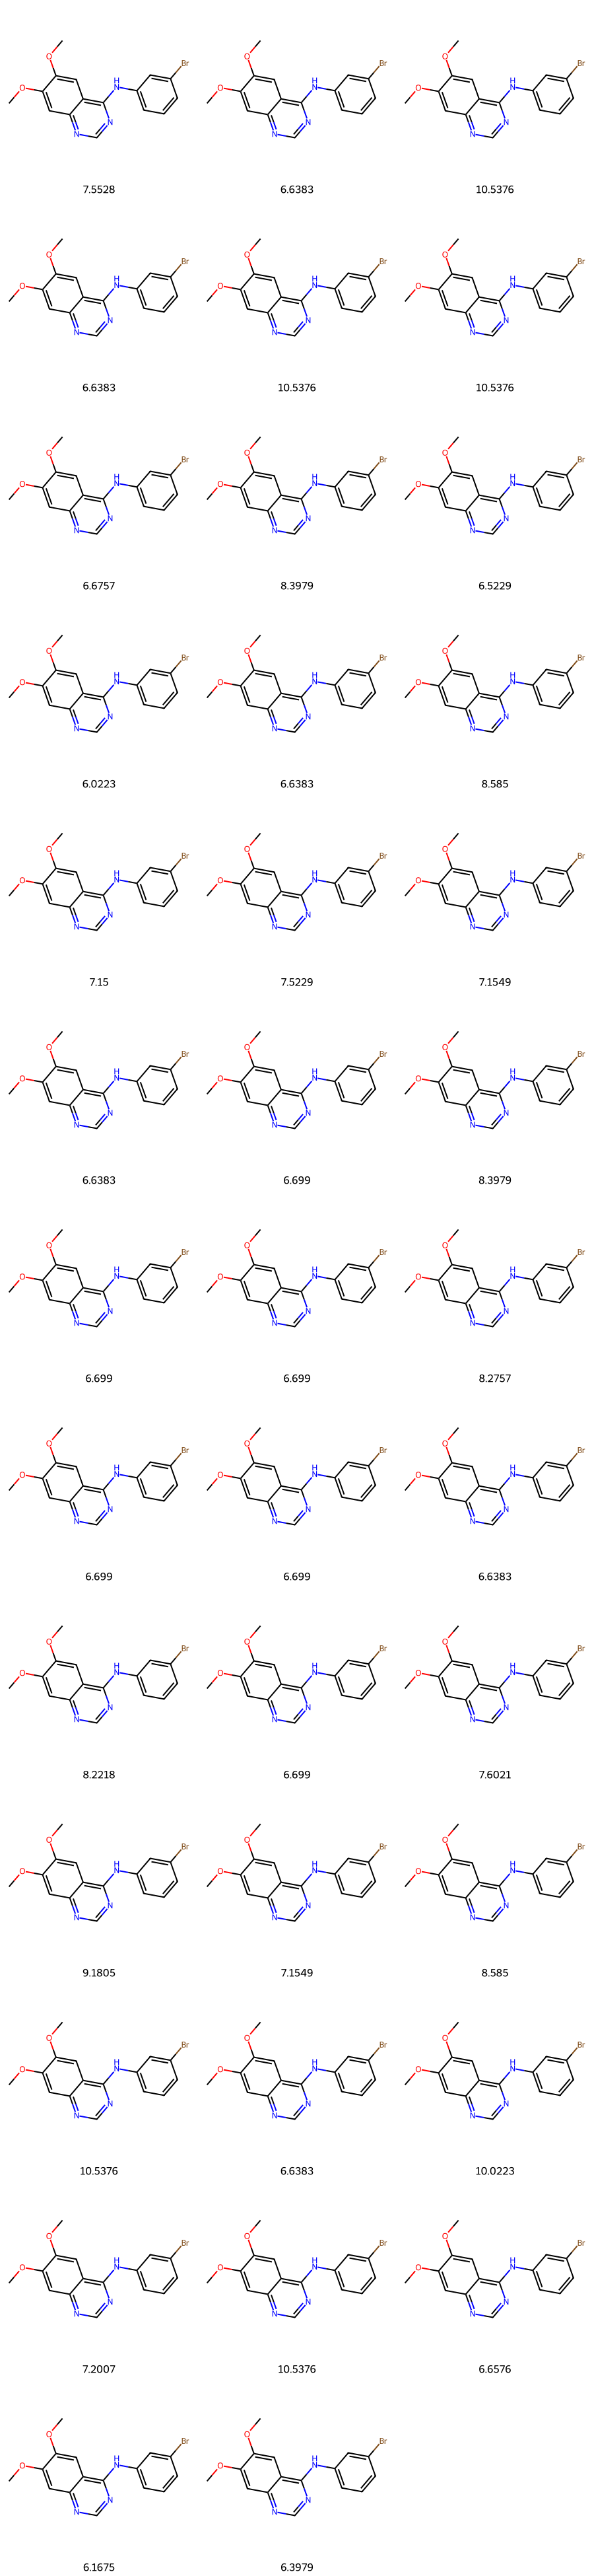

In [21]:
structs = org_df.loc[repeats['molecule_20'], 'Molecule']
acts = org_df.loc[repeats['molecule_20'], 'pIC50'].astype('str').tolist()
Draw.MolsToGridImage(structs, subImgSize = (300,300), legends = acts)

In [22]:
for idx in repeats.values():
    acts = org_df.loc[idx,'pIC50']
    if is_diff(acts):
        org_df.drop(idx, inplace = True)
        
    else:
        org_df.drop(idx[1:], inplace = True)
               
org_df.shape

(5788, 49)

Lost about 65.4% of the original data. 

<Axes: ylabel='Frequency'>

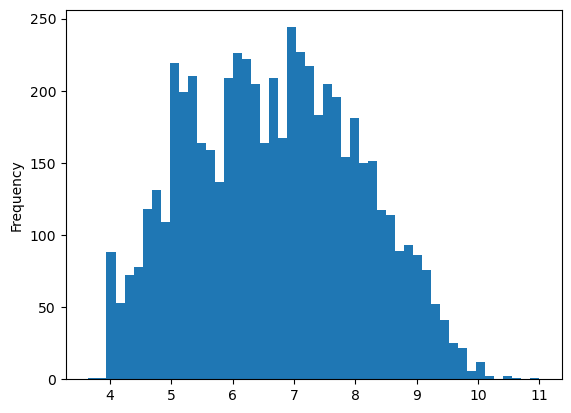

In [23]:
org_df['pIC50'].plot.hist(bins=50)

The data looks much cleaner now. Now QSAR and generative models can be made with it.

In [24]:
org_df.to_csv('EGFR_Chembl_clean.csv', index = False)